### 1. Importing Essential Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import pandas as pd
import seaborn as sns
import os
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import keras
from keras import backend
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, model_from_json, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3, ResNet152V2, VGG16,DenseNet201

#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 2. Data Collection

In [2]:
base_skin_dir = os.path.join('..', 'Data')
print(base_skin_dir)
print(os.path)
print(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

..\Data
<module 'ntpath' from 'c:\\Users\\dell\\AppData\\Local\\Programs\\Python\\Python310\\lib\\ntpath.py'>
..\Data\HAM10000_metadata.csv


In [3]:

from glob import glob
print(os.path.splitext)
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

<function splitext at 0x00000246A8093520>


In [4]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
print(os.path.join(base_skin_dir,'HAM10000_metadata.csv'))
df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
# Get list of directories in train_dir

# Create label_map dictionary
# label_map = {i: label for i, label in enumerate(labels)}
# num_classes=len(label_map)
# label_map


..\Data\HAM10000_metadata.csv


In [6]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

8

In [7]:

df['path'] = df['image_id'].map(imageid_path_dict.get) #Image Local Path
df['cell_type'] = df['dx'].map(lesion_type_dict.get) #Full 'dx' name
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes #Unique code for each 'dx'
print(df)

         lesion_id      image_id     dx dx_type   age     sex localization   
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp  \
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                                  path   
0    

In [8]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

In [9]:
num_classes=len(lesion_type_dict)

In [10]:
label_map = {'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}

# Map values in 'dx' column to integer labels using the dictionary
df['label'] = df['dx'].map(label_map)

In [11]:
print(df.head())
df['image'].map(lambda x: x.shape).value_counts()

     lesion_id      image_id   dx dx_type   age   sex localization   
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp  \
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                              path   
0  ..\Data\HAM10000_images_part_1\ISIC_0027419.jpg  \
1  ..\Data\HAM10000_images_part_1\ISIC_0025030.jpg   
2  ..\Data\HAM10000_images_part_1\ISIC_0026769.jpg   
3  ..\Data\HAM10000_images_part_1\ISIC_0025661.jpg   
4  ..\Data\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_type_idx   
0  Benign keratosis-like lesions               2  \
1  Benign keratosis-like lesions               2   
2  Benign keratosis-like lesions               2   
3  Benign keratosis-like lesions              

image
(75, 100, 3)    10015
Name: count, dtype: int64

### 2. Preprocessing

#### Noise Removal


In [13]:
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error
from skimage.restoration import denoise_bilateral

import plotly.graph_objects as go

from skimage.util import random_noise

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# path
img_test = cv2.imread('F:\Capstone\Code_final\Data\HAM10000_images_part_1\ISIC_0024306.jpg', 0)

In [14]:
img_test.shape

(450, 600)

<Figure size 1000x1000 with 0 Axes>

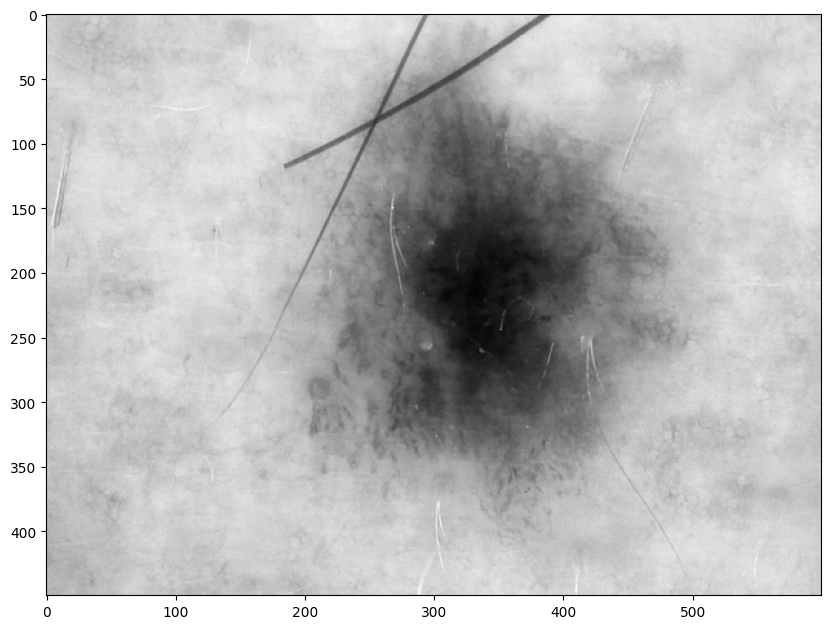

In [15]:
# Displaying the image
plt.figure(figsize=(10, 10))
plt.imshow(img_test, cmap='gray')

In [1]:
#Normalizing the images
#img_test = img_test.astype('float32') / 255.

#adding noise in data
noise_factor = 10

# img_test_noisy = random_noise(img_test, mode="s&p",clip=True, amount=noise_factor)
# img_test_noisy = random_noise(img_test, mode="s&p",clip=True, amount=noise_factor)
imgtest1=
imgtest2=
#img_test_noisy = img_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img_test.shape)

img_test_noisy = img_test

#img_test_noisy = np.clip(img_test_noisy, 0., 1.)

SyntaxError: invalid syntax (866094028.py, line 9)

C:\Users\dell\AppData\Local\Temp\ipykernel_10612\698816837.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_1image = peak_signal_noise_ratio(img_test, img_test_noisy_zncc)


<Figure size 1000x1000 with 0 Axes>

(<AxesSubplot: title={'center': 'Original'}>,
 Text(0.5, 1.0, 'Original'))

(([], []), ([], []))

(<AxesSubplot: title={'center': 'Noised Image'}>,
 Text(0.5, 1.0, 'Noised Image'))

Text(0.5, 0.25, 'After Noise Factor:50 => PSNR:14.1434 ZNCC:0.5275 SSIM:0.0229')

(([], []), ([], []))

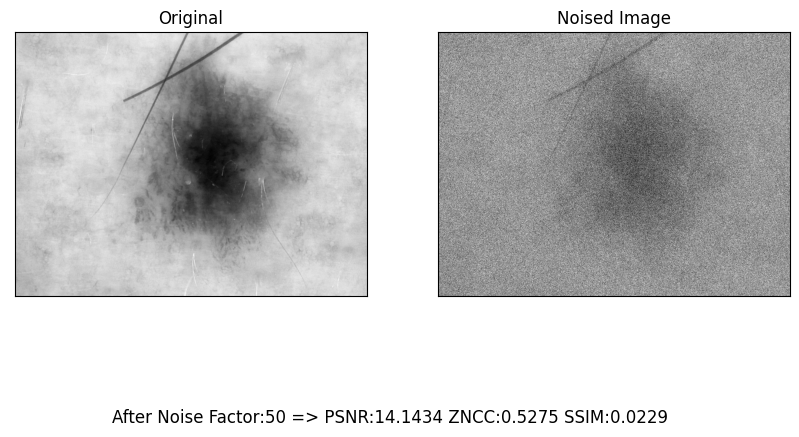

In [18]:
img_test_noisy_zncc = img_test + 50 * np.random.normal(loc=0.0, scale=1.0, size=img_test.shape)

zncc_1image = np.corrcoef(img_test.ravel(), img_test_noisy_zncc.ravel())[1,0]
psnr_1image = peak_signal_noise_ratio(img_test, img_test_noisy_zncc)
ssim_1image = structural_similarity(img_test, img_test_noisy_zncc, data_range=img_test.max() - img_test.min(), channel_axis=False)

plt.figure(figsize=(10, 10))

plt.subplot(1,2,1),plt.imshow(img_test, cmap='gray'),plt.title('Original',)
plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2),plt.imshow(img_test_noisy_zncc, cmap='gray'),plt.title('Noised Image')

plt.suptitle('After Noise Factor:50 => PSNR:%0.4f ZNCC:%0.4f SSIM:%0.4f' %(psnr_1image, zncc_1image, ssim_1image), y=0.25)
 
plt.xticks([]), plt.yticks([])

In [19]:
img_test_noisy = img_test_noisy.astype('float32')

<Figure size 1000x1000 with 0 Axes>

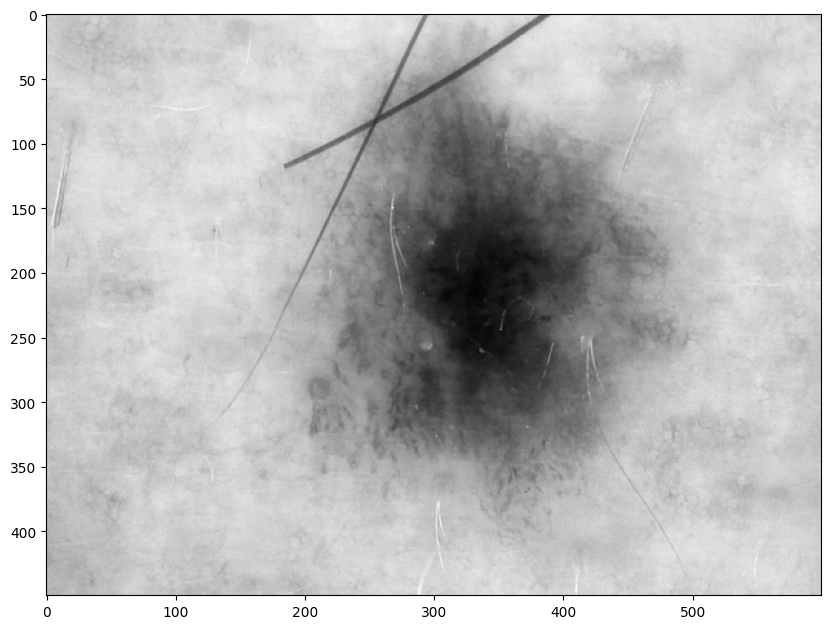

In [20]:
# Displaying the image
plt.figure(figsize=(10, 10))
plt.imshow(img_test_noisy, cmap='gray')

plt.savefig('noised.png')

<Figure size 2000x2000 with 0 Axes>

(<AxesSubplot: title={'center': 'Original'}>,
 Text(0.5, 1.0, 'Original'))

(([], []), ([], []))

(<AxesSubplot: title={'center': 'Noised Image'}>,
 Text(0.5, 1.0, 'Noised Image'))

(([], []), ([], []))

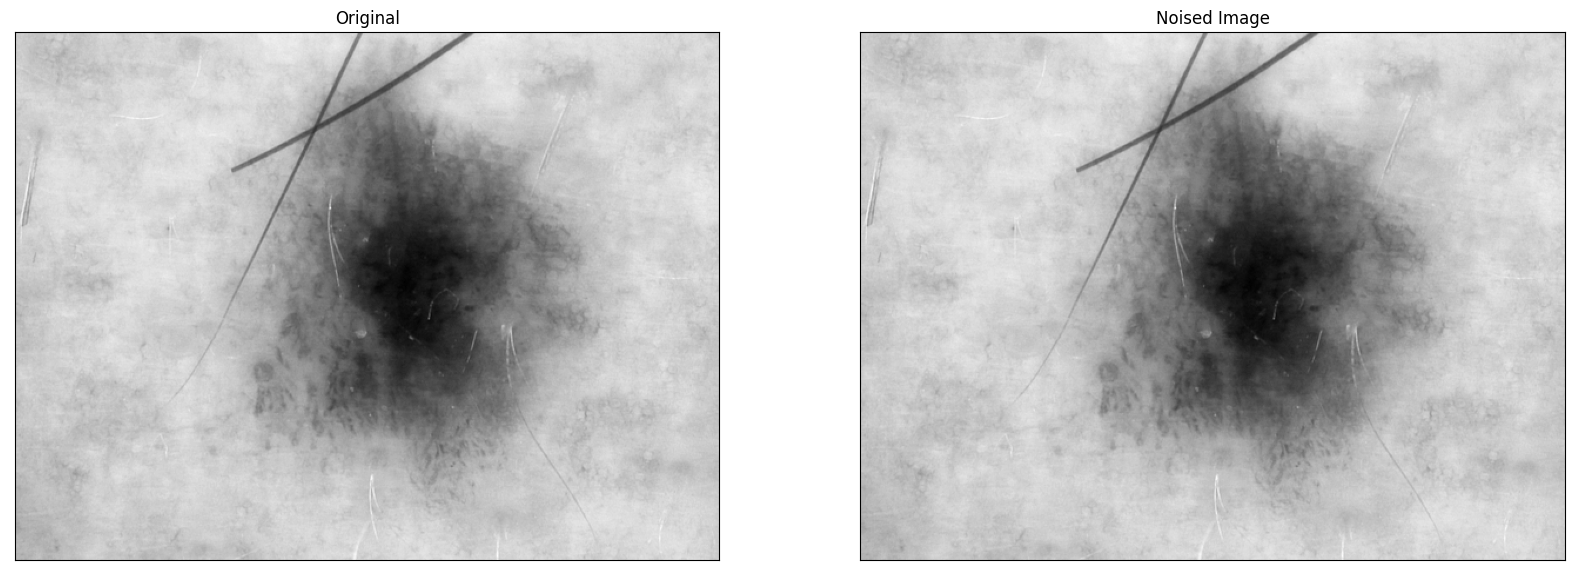

In [22]:
plt.figure(figsize=(20, 20))

plt.subplot(1,2,1),plt.imshow(img_test, cmap='gray'),plt.title('Original',)
plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2),plt.imshow(img_test_noisy, cmap='gray'),plt.title('Noised Image')
 
plt.xticks([]), plt.yticks([])

In [23]:
kernel = np.ones((3,3), np.float32)/9

denoised_mean = cv2.filter2D(img_test_noisy, -1,kernel)

In [24]:
def function_image(img_test, img_test_noisy, denoised, filter_type):

    plt.figure(figsize=(20, 20))

    plt.subplot(1,3,1),plt.imshow(img_test, cmap='gray'),plt.title('Original',)
    plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.imshow(img_test_noisy, cmap='gray'),plt.title('Noised Image')
    plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(denoised, cmap='gray'),plt.title(filter_type)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    plt.savefig(str(filter_type)+'.png')

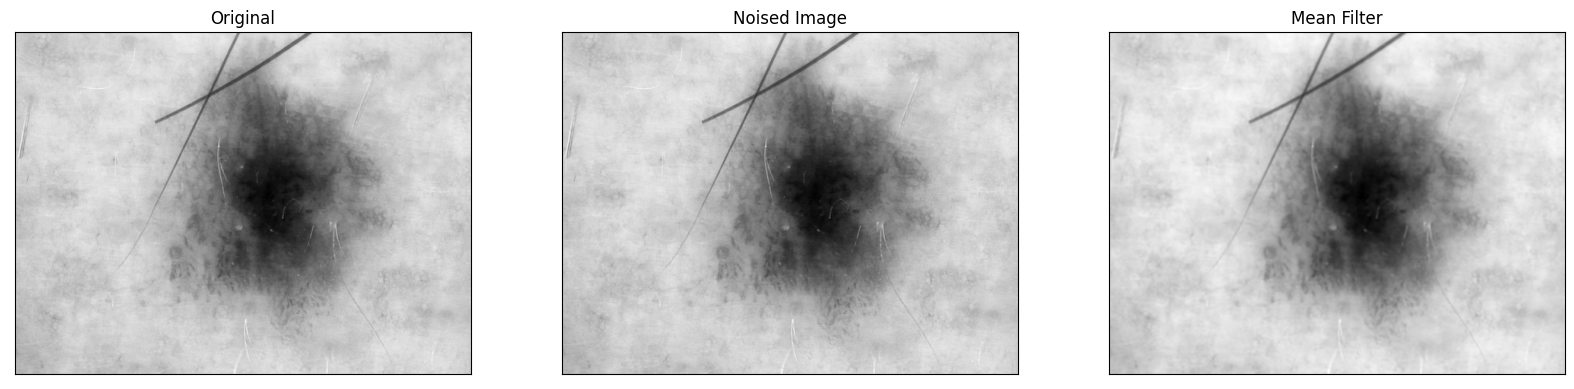

<Figure size 640x480 with 0 Axes>

In [32]:
function_image(img_test, img_test_noisy, denoised_mean,'Mean Filter')

In [27]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [28]:
def evaluate_image(filtername, img_test, img_test_noisy, denoised):
    
    # Calculating Values
    psnr_orgnoised = peak_signal_noise_ratio(img_test, img_test_noisy)
    psnr_orgdenoised = peak_signal_noise_ratio(img_test, denoised)
    
    ssim_orgnoised = structural_similarity(img_test, img_test_noisy, channel_axis=False)
    ssim_orgdenoised = structural_similarity(img_test, denoised, channel_axis=False)
    
    # Putting all values in DataFrame
    data = [{'Filter Name':filtername,'PSNR ORG-NOISED': psnr_orgnoised, 'PSNR ORG-DENOISED': psnr_orgdenoised, 'SSIM ORG-NOISED':ssim_orgnoised, 'SSIM ORG-DENOISED':ssim_orgdenoised}] 
    df = pd.DataFrame(data)
    
    return df

In [29]:
# Parameters: Width and Height of the kernel which should be positive and odd. 
# Standard Deviation in the X and Y directions, sigmaX and sigmaY.

denoised_gaussian_05 = cv2.GaussianBlur(img_test_noisy,(3,3),0.5)

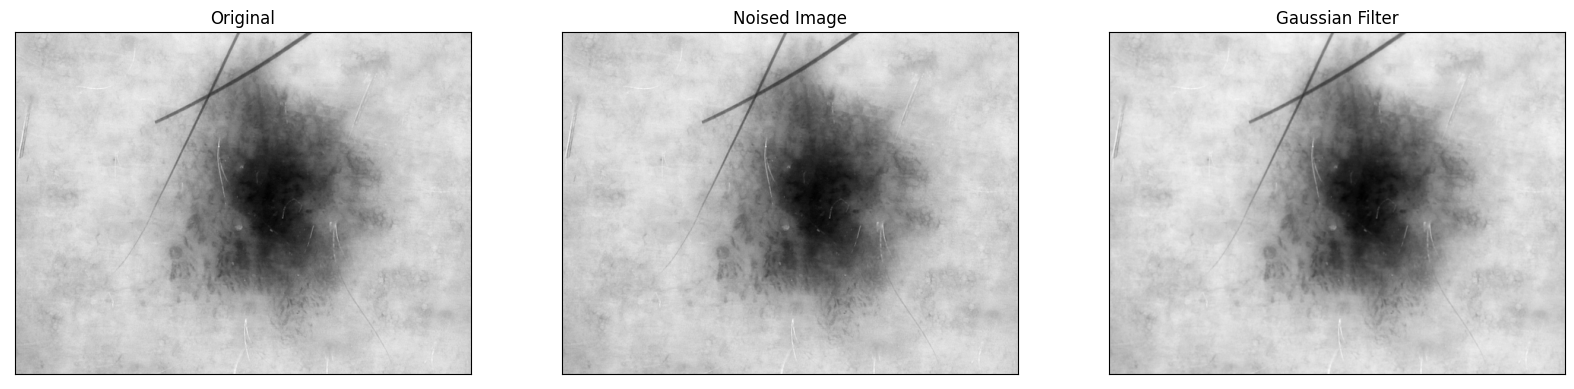

<Figure size 640x480 with 0 Axes>

In [30]:
function_image(img_test, img_test_noisy, denoised_gaussian_05, 'Gaussian Filter')

### Histogram equalization

#### Removing Noise Artifacts and Enhancing Contast

In [19]:
import os
import cv2

def process_images_in_folder(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        # Check if the file is an image (you can add more image extensions if needed)
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Read the image
            image_path = os.path.join(input_folder, filename)
            img = cv2.imread(image_path)  # Read image in color (BGR)

            # Convert image to YUV color space
            img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

            # Apply Histogram Equalization to Y channel
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

            # Convert image back to BGR color space
            img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

            # Save the result
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, img_output)

            print(f"Processed image '{filename}' and saved result to '{output_path}'")

# Specify the input folder containing images
input_folder = "F:/Capstone/Code_final/Data/HAM10000_images_part_1"

# Specify the output folder where processed images will be saved
output_folder = "F:/Capstone/Code_final/Data/Processed_Images"

# Process images in the input folder and save the results to the output folder
process_images_in_folder(input_folder, output_folder)


Processed image 'ISIC_0024306.jpg' and saved result to 'F:/Capstone/Code_final/Data/Processed_Images\ISIC_0024306.jpg'
Processed image 'ISIC_0024307.jpg' and saved result to 'F:/Capstone/Code_final/Data/Processed_Images\ISIC_0024307.jpg'
Processed image 'ISIC_0024308.jpg' and saved result to 'F:/Capstone/Code_final/Data/Processed_Images\ISIC_0024308.jpg'
Processed image 'ISIC_0024309.jpg' and saved result to 'F:/Capstone/Code_final/Data/Processed_Images\ISIC_0024309.jpg'
Processed image 'ISIC_0024310.jpg' and saved result to 'F:/Capstone/Code_final/Data/Processed_Images\ISIC_0024310.jpg'
Processed image 'ISIC_0024311.jpg' and saved result to 'F:/Capstone/Code_final/Data/Processed_Images\ISIC_0024311.jpg'
Processed image 'ISIC_0024312.jpg' and saved result to 'F:/Capstone/Code_final/Data/Processed_Images\ISIC_0024312.jpg'
Processed image 'ISIC_0024313.jpg' and saved result to 'F:/Capstone/Code_final/Data/Processed_Images\ISIC_0024313.jpg'
Processed image 'ISIC_0024314.jpg' and saved res

### Resizing and Cropping

### 3. Segmentation

### Otsu's Thresholding Segmentation:

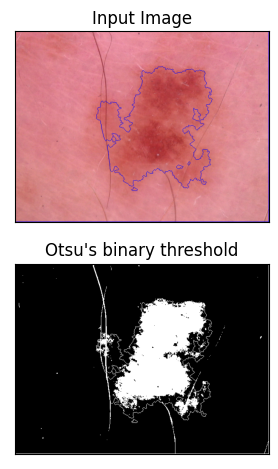

In [14]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
image_path = "F:/Capstone/Code_final/Data/Processed_Images/ISIC_0024307.jpg"
img=cv2.imread(image_path)
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(closing,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
# Threshold
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.subplot(211),plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(thresh, 'gray')
plt.imsave(r'thresh.png',thresh)
plt.title("Otsu's binary threshold"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

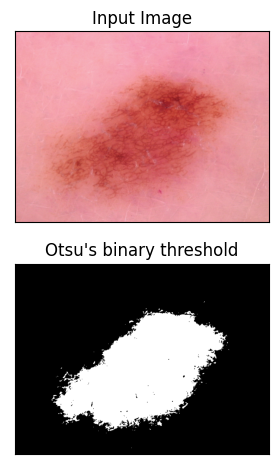

In [14]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
image_path =  "F:\Capstone\Code_final\Data\HAM10000_images_part_1\ISIC_0024311.jpg"
img = cv2.imread(image_path)

b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(closing,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
# Threshold
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.subplot(211),plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(thresh, 'gray')
plt.imsave(r'thresh.png',thresh)
plt.title("Otsu's binary threshold"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

In [16]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

def process_image(image_path, output_folder):
    # Load the image
    img = cv2.imread(image_path)
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Otsu's thresholding
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Noise removal
    kernel = np.ones((2,2), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Sure background area
    sure_bg = cv2.dilate(closing, kernel, iterations=3)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 3)
    ret, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)
    
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    
    # Mark the region of unknown with zero
    markers[unknown==255] = 0
    
    # Watershed segmentation
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]
    
    # Save processed image
    output_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_path, img)

# Input and output folders
input_folder = "F:/Capstone/Code_final/Data/Processed_Images"
output_folder = "F:/Capstone/Code_final/Data/Segmented_Images"

# Process images in the input folder and save results in the output folder
for filename in os.listdir(input_folder):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(input_folder, filename)
        process_image(image_path, output_folder)


### Region Based Segmentation:

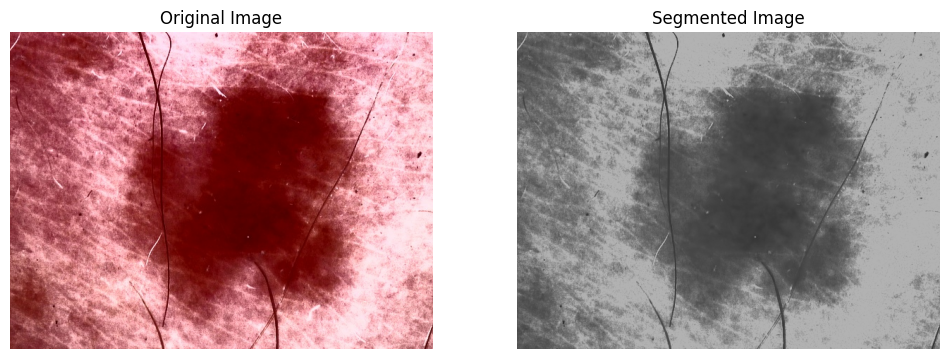

In [6]:
import matplotlib.pyplot as plt
from skimage import io, color, morphology, filters
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.segmentation import clear_border

# Load the image from the specified path
image_path = "F:/Capstone/Code_final/Data/Processed_Images/ISIC_0024307.jpg"
image = io.imread(image_path)

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Apply Otsu's thresholding to segment the image
thresh = filters.threshold_otsu(gray_image)
binary_image = gray_image > thresh

# Remove small objects and clear borders
binary_image = morphology.remove_small_objects(binary_image, min_size=1000)
binary_image = clear_border(binary_image)

# Label regions
label_image = label(binary_image)

# Colorize regions
image_label_overlay = label2rgb(label_image, image=image)

# Display original image and segmented image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(image_label_overlay)
axes[1].set_title('Segmented Image')
axes[1].axis('off')
plt.show()


## Augmentation

### Hair Removal:

(450, 600, 3)


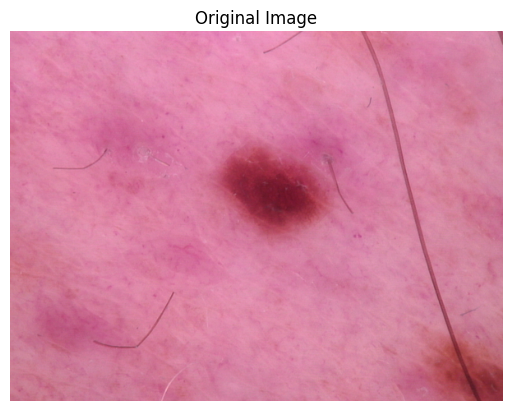

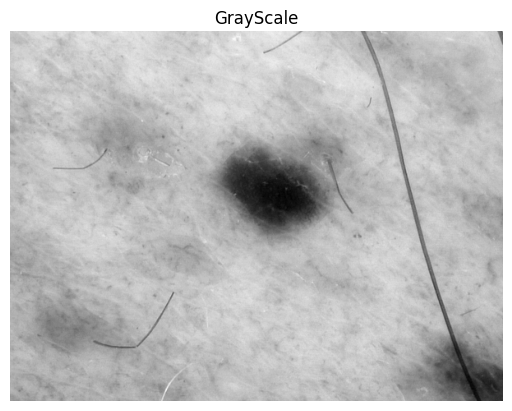

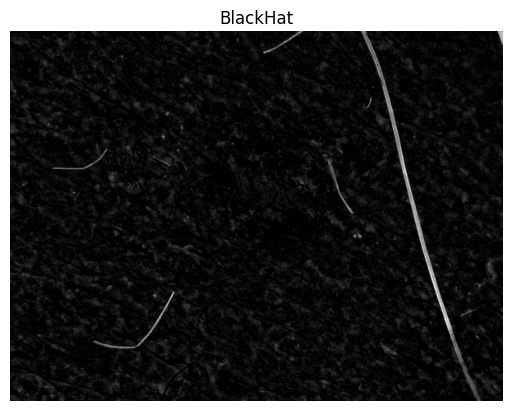

(450, 600)


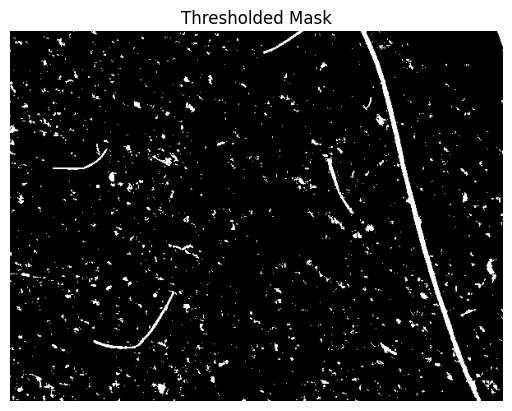

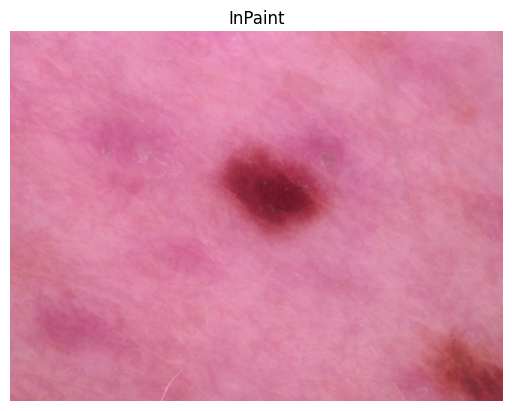

In [1]:
# -*- coding: utf-8 -*-
"""
Following are the DHR tasks followed in this example code:
    
    -- Applying Morphological Black-Hat transformation
    -- Creating the mask for InPainting task
    -- Applying inpainting algorithm on the image

"""

import cv2
import matplotlib.pyplot as plt

src = cv2.imread("F:/Capstone/Code_final/Data/HAM10000_images_part_1/ISIC_0024389.jpg")

print(src.shape)
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')
plt.show()

# Convert the original image to grayscale
grayScale = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
plt.imshow(grayScale, cmap='gray')
plt.title("GrayScale")
plt.axis('off')
plt.show()

# Kernel for the morphological filtering
kernel = cv2.getStructuringElement(1, (17, 17))

# Perform the blackHat filtering on the grayscale image to find the 
# hair countours
blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
plt.imshow(blackhat, cmap='gray')
plt.title("BlackHat")
plt.axis('off')
plt.show()

# intensify the hair countours in preparation for the inpainting 
# algorithm
ret, thresh2 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
print(thresh2.shape)
plt.imshow(thresh2, cmap='gray')
plt.title("Thresholded Mask")
plt.axis('off')
plt.show()

# inpaint the original image depending on the mask
dst = cv2.inpaint(src, thresh2, 1, cv2.INPAINT_TELEA)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title("InPaint")
plt.axis('off')
plt.show()
